### Imports

In [1]:
from utils import *
import json # to load the data dictionaries
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.api.types import CategoricalDtype
from operator import attrgetter
from celluloid import Camera
import os
from IPython.display import HTML

%matplotlib inline

### Function Definitions

In [41]:
def age_to_group(x):
    """
    Returns a string of an age group.

    Takes in an Interval Object, extracts upper and lower limits and places them in a string

    Example: 
    age_to_group(Interval([30, 40)))
    > '30-39'
    """
    return f'{str(x.left)}-{str(x.right - 1)}'

In [42]:
def dict_to_dataframe(input_dict):
    """
    Returns a dataframe of age groups counts at 10 year intervals for each gender.
    """
    # create an empty list to hold the final data
    df = pd.DataFrame()
    
    # create a dataframe with the age and gender of each person
    for gender, ages in input_dict.items():
        df = pd.concat([df,pd.DataFrame({'Age': ages, 'Gender':[gender] * len(ages)})])
    df.reset_index(inplace=True, drop=True)
    
    df['Age'] = pd.cut(df.Age.astype('int'),range(-0,101,10), right=False).map(age_to_group)
    df['Age'] = pd.Categorical(df.Age, categories=df.Age.cat.categories[::-1], ordered=True)
    df['Gender'] = df.Gender.apply(str.capitalize)

    df = pd.crosstab(df['Age'], df['Gender'], df['Gender'], aggfunc='count').reset_index()
    df.Male *= -1

    # create a pandas dataframe from the output data and return it
    return df


In [43]:
def get_paths():
    """
    Returns a list of paths for each simulation. 
    Simulation Paths are indicated by start with 'Pop'.
    """
    return ['./../data/' + directory for directory in os.listdir('../data') \
    if directory.startswith('Pop')]

In [44]:
def extract_data(path):
    """
    Combines three existing functions to save the data from a simulation.
    Simulation is specified by passing a path variable.
    """
    path_composition = path + '/composition_data.txt'
    path_death = path + '/death_data.txt'
    path_location = path + '/location_data.txt'
    extract_composition_data(path_composition)
    extract_death_data(path_death)
    extract_location_data(path_location)

In [6]:
def load_dictionaries(path):
    """
    Returns three dictionaries containing data about the gender, age and location of agents on each run
    and the age and vaccination status of those who died.

    Example:
    dict_composition, dict_death, dict_location = load_dictionaries(path)
    """
    path_composition = path + '/composition_data.json'
    path_death = path + '/death_data.json'
    path_location = path + '/location_data.json'
    print(path_composition)

    with open(path_composition, 'r') as f:
        dict_composition = json.loads(f.read())

    with open(path_death, 'r') as f:
        dict_death = json.loads(f.read())

    with open(path_location, 'r') as f:
        dict_location = json.loads(f.read())
    
    return dict_composition, dict_death, dict_location

In [7]:
def find_prevalence_points(infection_rates):
    """
    Returns the days on which the first two prevalence points occurred.
    A prevalence point is when the proportion of the infected population exceeds 50%.
    Another way to understand this is when the number of infected equals the number of healthy.
    Handles cases where there are no prevalence points.

    Args:
    infection_rates: a list of floats representing the daily infection rates over time.

    Returns:
    A list containing two integers: the index of the first and second prevalence points, respectively.
    If there is only one prevalence point, the second index is set to -1.
    If there are no prevalence points, the function returns [-1, -1].
    """
    # Changing to a boolean list so I can easily check differences between past and current variables
    # If there is a change in boolean value it means a prevalence point was passed
    boolean_list = [x > 0.5 for x in infection_rates]
    indices = []
    prev_bool = boolean_list[0]
    for i in range(1, len(boolean_list)):
        curr_bool = boolean_list[i]
        if curr_bool != prev_bool:
            indices.append(i)
            prev_bool = curr_bool
    
    # This is for handling if there are less than two prevalence points
    if len(indices) >= 2:
        return indices
    elif len(indices) == 1:
        return indices + [-1]
    else: 
        return [-1, -1]

### Creating Dataframe of Simulations and Key Metrics

In [8]:
df = pd.DataFrame()
dict_simulations = {}
for path in get_paths():
    # Loading in the data using the extract_data and load_dictionaries functions
    extract_data(path)
    dict_composition, dict_death, dict_location = load_dictionaries(path)
    dict_simulations[path] = {'composition':dict_composition,'death':dict_death, 'location':dict_location}

    # Calculating the number of steps for a simulation
    steps = len(dict_location.keys()) - 1 if len(dict_location.keys()) < 1001 else 1001

    # Calculating the key metrics: total deaths, highest infection rate, 
    # first_prevalence_point, second_prevalence_point
    total_deaths = len(dict_death['age'])

    # Count of each status type in a tuple for each step 
    status = [(
        len(dict_location[str(i)]['healthy']['x']) +\
        len(dict_location[str(i)]['recovered']['x']), 
        len(dict_location[str(i)]['infected']['x'])
    ) for i in range(steps)]
    infection_rates = [t[1] / sum(t) if sum(t) > 0 else 0 for t in status]
    highest_infection_rate = max(infection_rates)
    highest_infection_rate_day = infection_rates.index(highest_infection_rate)
    prevalence_points = find_prevalence_points(infection_rates)
    parameters = path[13:].split('_')
    population = int(parameters[0])
    initial_infection_rate = float(parameters[1][3:])
    fertility_rate = float(parameters[2][4:])
    mortality_rate = float(parameters[3][4:])
    infection_prob = float(parameters[4][3:])
    infection_radius = float(parameters[5][4:])
    df_tmp = pd.DataFrame({
        'Simulation':[path.split('/')[-1]],
        'Steps':[steps],
        'Population':[population],
        'InitialInfectionRate':[initial_infection_rate],
        'FertilityRate':[fertility_rate],
        'MortalityRate':[mortality_rate], 
        'InfectionProb':[infection_prob],
        'InfectionRadius':[infection_radius],
        'TotalDeaths':[total_deaths], 
        'HighestInfectionRate':[highest_infection_rate], 
        'HighestInfectionRateDay':[highest_infection_rate_day],
        'FirstPrevalencePoint':[prevalence_points[0]], 
        'SecondPrevalencePoint':[prevalence_points[1]]
        }
    )
    df = pd.concat([df, df_tmp]).reset_index(drop=True)

Missing data on day 153, current value ['']
May be due to error at the end of the data.
Missing data on day 153, current value ['']
May be due to error at the end of the data.
./../data/Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4/composition_data.json
Missing data on day 106, current value ['']
May be due to error at the end of the data.
Missing data on day 106, current value ['']
May be due to error at the end of the data.
./../data/Pop100_ICR0.01_Fert0.2_Mort4.0_CCP0.75_Dist4/composition_data.json
Missing data on day 1001, current value ['']
May be due to error at the end of the data.
Missing data on day 1001, current value ['']
May be due to error at the end of the data.
./../data/Pop100_ICR0.05_Fert0.2_Mort4.0_CCP0.95_Dist4/composition_data.json
Missing data on day 1001, current value ['']
May be due to error at the end of the data.
Missing data on day 1001, current value ['']
May be due to error at the end of the data.
./../data/Pop300_ICR0.01_Fert0.01_Mort100.0_CCP0.999_Dist20/

In [45]:
def determine_outbreak_type(outbreak):
    """
    Returns Outbreak Type Label for each simulation.

    Slight occurs when infection rate never exceeds 50%
    Moderate occurs when infection rate exceeds 50% then drops below 50% again.
    Severe occurs when infection rate exceeds 50% and remains above.
    """
    if outbreak.FirstPrevalencePoint == -1 and outbreak.SecondPrevalencePoint == -1:
        return 'Slight'
    elif outbreak.SecondPrevalencePoint == -1:
        return 'Severe'
    else:
        return 'Moderate'

In [10]:
def bin_density(x):
    """
    Returns the Population Density label based on the simulation parameter.
    """
    if x < 200:
        return 'Lower'
    elif x < 700:
        return 'Moderate'
    else:
        return 'High'

In [46]:
def bin_infection_rate(x):
    """
    Returns the Infection Rate label based on the simulation parameter.
    """
    if x <= .5:
        return 'Low'
    elif x <= .75:
        return 'Moderate'
    else:
        return'High'

In [12]:
def bin_mortality_rate(x):
    """
    Returns the Mortality Rate label based on the simulation parameter.
    """
    if x <= 5:
        return 'Low'
    elif x <= 30:
        return 'Moderate'
    else:
        return'High'

In [13]:
df['OutbreakType'] = pd.Categorical(
    df.apply(determine_outbreak_type, axis=1), 
    ['Slight', 'Moderate', 'Severe'], ordered=True
)
df['PopulationDensity'] = df.Population.apply(bin_density)
df['InfectionRate_cat'] = df.InfectionProb.apply(bin_infection_rate)
df['MortalityRate_cat'] = df.MortalityRate.apply(bin_mortality_rate)

In [14]:
df

,Simulation,Steps,Population,InitialInfectionRate,FertilityRate,MortalityRate,InfectionProb,InfectionRadius,TotalDeaths,HighestInfectionRate,HighestInfectionRateDay,FirstPrevalencePoint,SecondPrevalencePoint,OutbreakType,PopulationDensity,InfectionRate_cat,MortalityRate_cat
0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4,153,100,0.01,0.050,4.0,0.7500,4.0,4,0.990000,5,3,-1,Severe,Lower,Moderate,Low
1,Pop100_ICR0.01_Fert0.2_Mort4.0_CCP0.75_Dist4,106,100,0.01,0.200,4.0,0.7500,4.0,0,0.176471,32,-1,-1,Slight,Lower,Moderate,Low
2,Pop100_ICR0.05_Fert0.2_Mort4.0_CCP0.95_Dist4,1001,100,0.05,0.200,4.0,0.9500,4.0,0,0.485149,23,-1,-1,Slight,Lower,High,Low
3,Pop300_ICR0.01_Fert0.01_Mort100.0_CCP0.999_Dist20,1001,300,0.01,0.010,100.0,0.9990,20.0,123,0.985437,19,2,-1,Severe,Moderate,High,High
4,Pop300_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4,1001,300,0.01,0.050,4.0,0.7500,4.0,16,0.466431,121,-1,-1,Slight,Moderate,Moderate,Low
5,Pop300_ICR0.01_Fert0.2_Mort4.0_CCP0.75_Dist4,1001,300,0.01,0.200,4.0,0.7500,4.0,13,0.632107,27,21,39,Moderate,Moderate,Moderate,Low
6,Pop400_ICR0.05_Fert0.2_Mort20.0_CCP0.5_Dist4,1001,400,0.05,0.200,20.0,0.5000,4.0,62,0.534884,24,21,29,Moderate,Moderate,Low,Moderate
7,Pop900_ICR0.01_Fert0.001_Mort100.0_CCP0.999_Dist4,1001,900,0.01,0.001,100.0,0.9990,4.0,493,0.992410,38,2,-1,Severe,High,High,High
8,Pop900_ICR0.01_Fert0.001_Mort1000.0_CCP0.9999_...,152,900,0.01,0.001,1000.0,0.9999,4.0,573,0.976019,12,1,-1,Severe,High,High,High
9,Pop900_ICR0.01_Fert0.2_Mort4.0_CCP0.99_Dist4,966,900,0.01,0.200,4.0,0.9900,4.0,154,0.924294,17,9,426,Moderate,High,High,Low


### Creating Simulation Dictionaries
These will be used to map the OutbreakType, InfectionRate and Mortality labels to a simulation

In [15]:
dict_sim_density = dict(zip(df.Simulation,df.PopulationDensity))
dict_sim_mortality = dict(zip(df.Simulation,df.MortalityRate_cat))
dict_sim_infection = dict(zip(df.Simulation,df.InfectionRate_cat))
dict_sim_severity = dict(zip(df.Simulation,df.OutbreakType))

### Key Visuals

In [25]:
df_agg = df.groupby('OutbreakType', as_index=False)[
    [
    'Steps', 'TotalDeaths', 'HighestInfectionRate', 'HighestInfectionRateDay'
    ]
    ].mean()
df_agg

,OutbreakType,Steps,TotalDeaths,HighestInfectionRate,HighestInfectionRateDay
0,Slight,702.666667,5.333333,0.376017,58.666667
1,Moderate,994.000000,153.400000,0.797593,19.800000
2,Severe,576.750000,298.250000,0.985966,18.500000


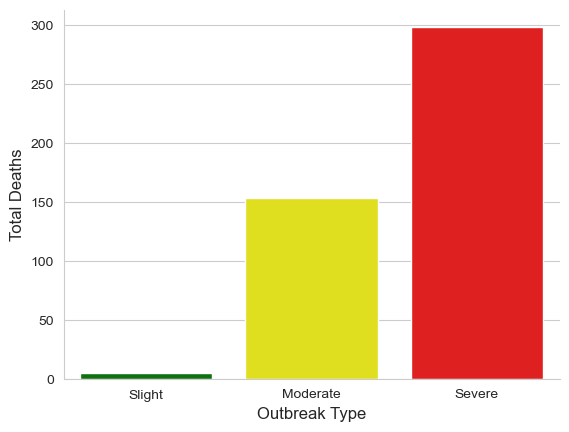

In [ ]:
sns.barplot(data=df_agg, x='OutbreakType', y='TotalDeaths',palette=['Green', 'yellow', 'red'])
plt.xlabel('Outbreak Type', fontsize=12)
plt.ylabel('Total Deaths', fontsize=12)
plt.savefig('../images/overview/outbreak_deaths.png')

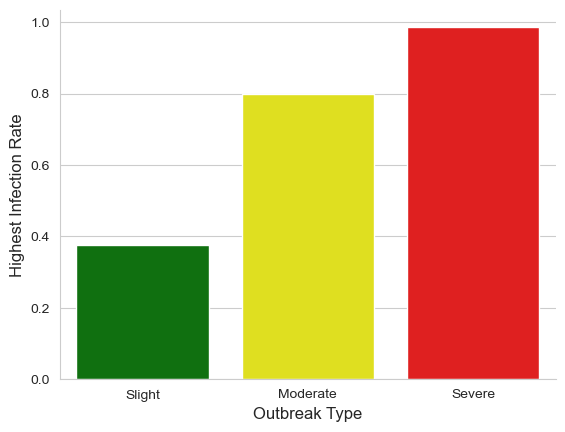

In [ ]:
sns.barplot(data=df_agg, x='OutbreakType', y='HighestInfectionRate', palette=['Green', 'yellow', 'red'])
plt.xlabel('Outbreak Type', fontsize=12)
plt.ylabel('Highest Infection Rate', fontsize=12)
plt.savefig('../images/overview/outbreak_infection.png')

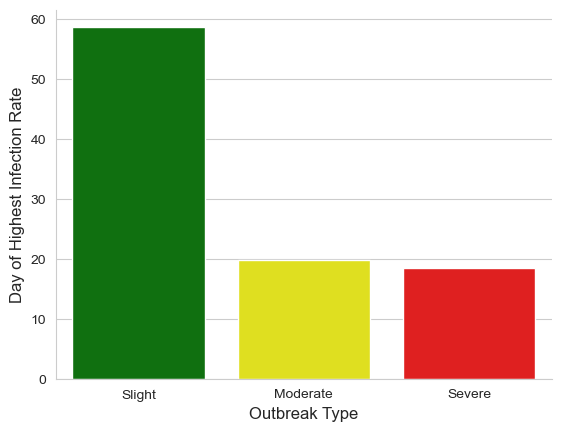

In [ ]:
sns.barplot(data=df_agg, x='OutbreakType', y='HighestInfectionRateDay', palette=['Green', 'yellow', 'red'])
plt.xlabel('Outbreak Type', fontsize=12)
plt.ylabel('Day of Highest Infection Rate', fontsize=12)
plt.savefig('../images/overview/outbreak_infection_day.png')

### Population Pyramid

In [17]:
def label(tick):
    """
    Removes negative sign from a tick label. 

    \u2212 is used in tick labels for negation. It is similar to a hyphen but it is a little larger. 
    """
    n = tick.get_text()
    return n[1:] if n.startswith('\u2212') else n

In [18]:
def pop_pyramid(x, simulation):
    """
    Generates a population pyramid visual for the population at a point (day) in a simulation.

    Arguments:
    x: The day in the simulation (usually between 0 and 1000)
    simulation: path used as a key to access data
    """
    df = dict_to_dataframe(dict_simulations[simulation]['composition'][str(x)])
    male = sns.barplot(x='Male', y='Age', data=df, palette="Blues")
    female = sns.barplot(x='Female', y='Age', data=df, palette="Greens")
    plt.title(f"Population Pyramid on Day {x}")
    plt.xlabel("Male" + ' ' * 40 + "Female", x=0.5)

    plt.grid()
    ticks = male.get_xticklabels(True)
    plt.xticks(ticks=[abs(tick.get_unitless_position()[0]) for tick in ticks],labels=[label(tick) for tick in ticks])

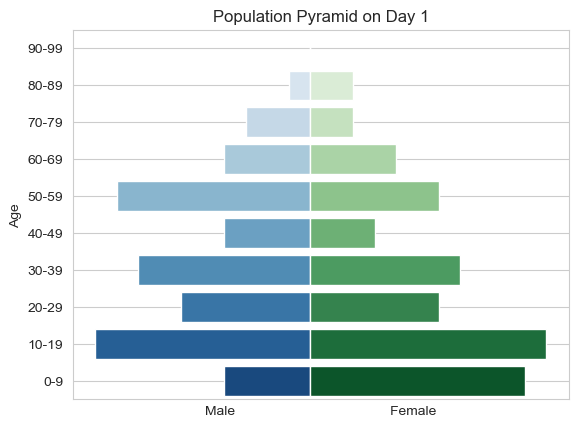

In [153]:
path = get_paths()[0]
pop_pyramid(1, path)

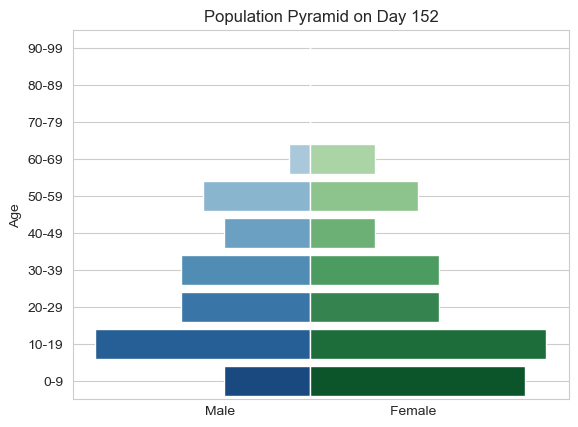

In [154]:

pop_pyramid(len(dict_simulations[path]['location']) - 2, path)

### Deaths Plot

In [47]:
sns.set_style('whitegrid');
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

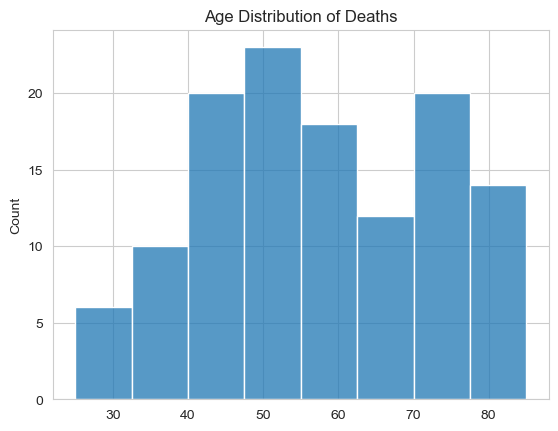

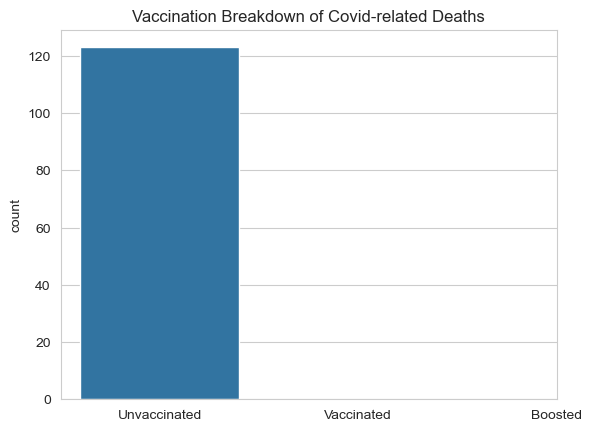

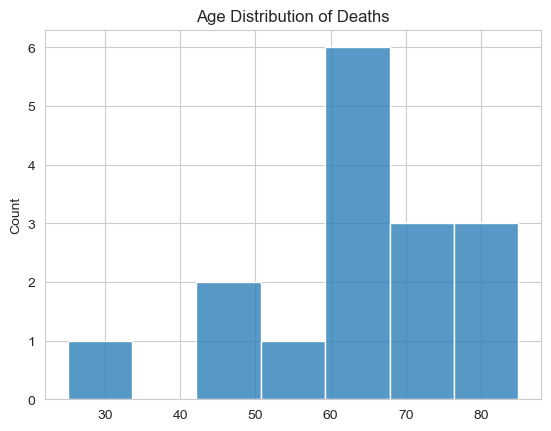

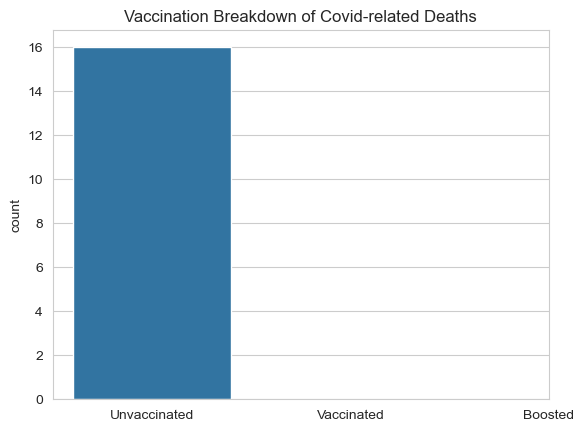

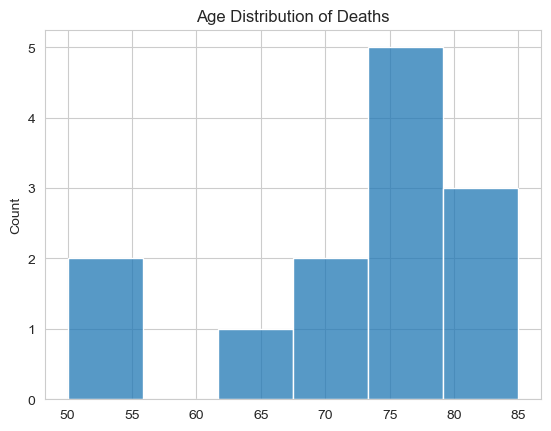

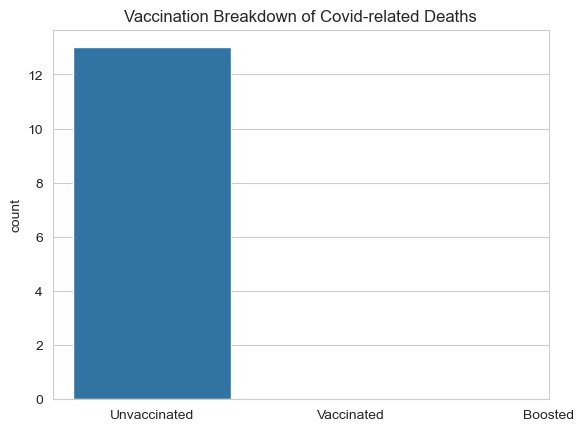

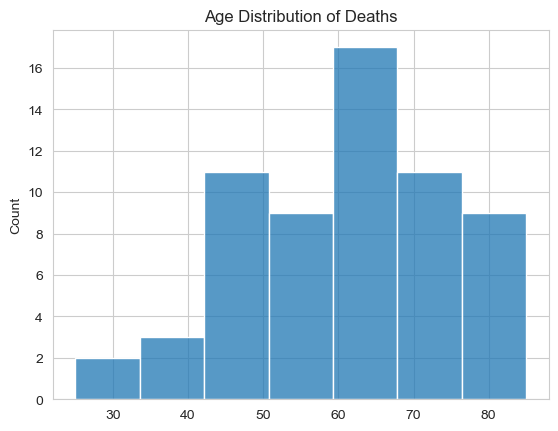

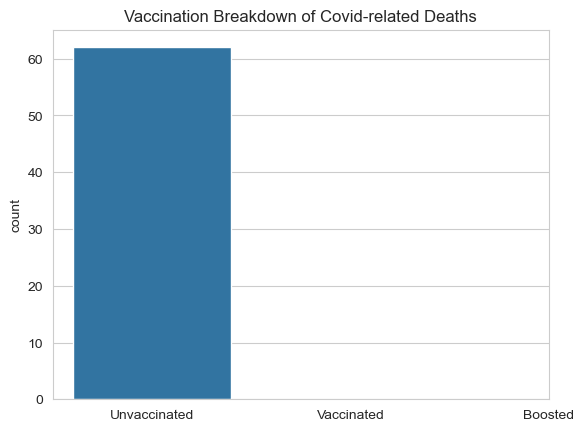

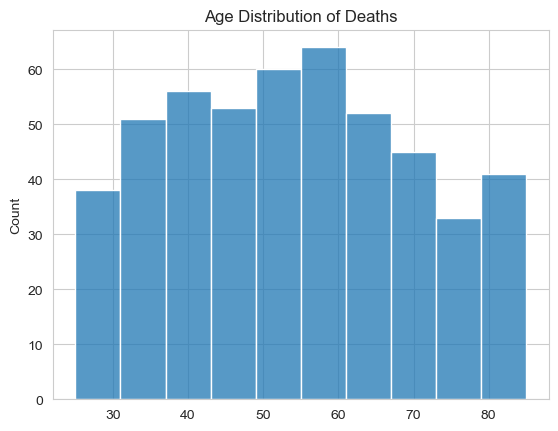

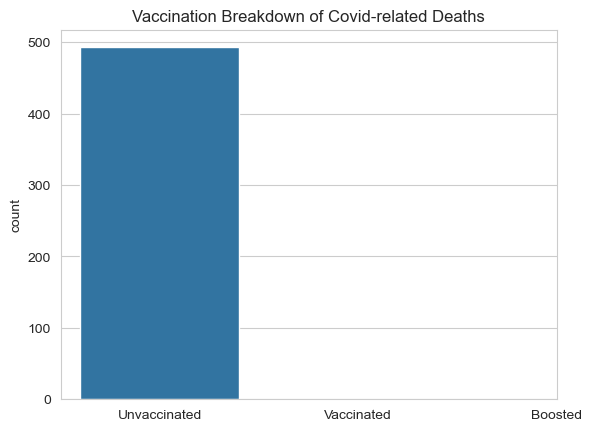

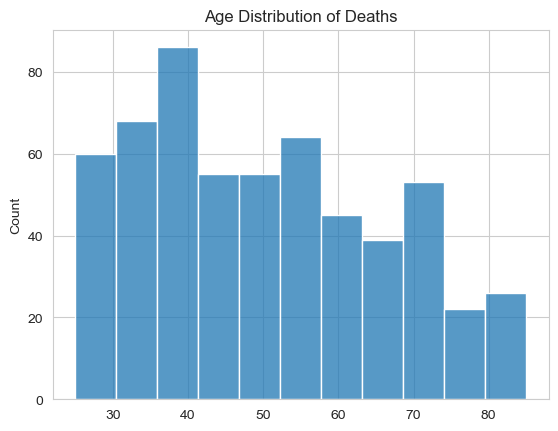

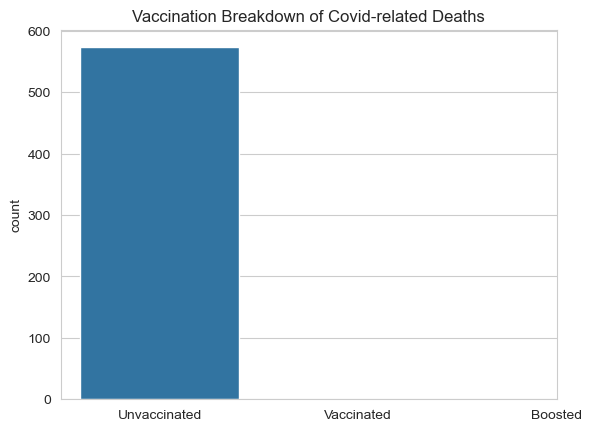

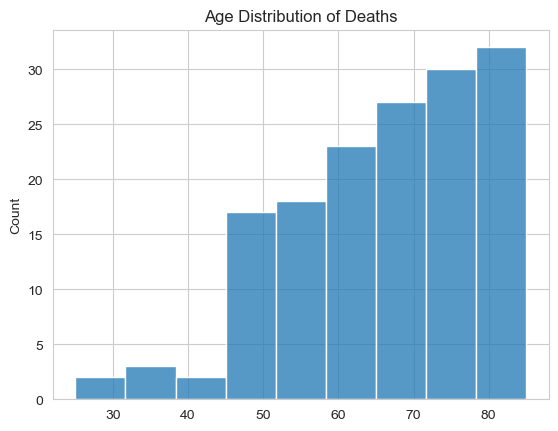

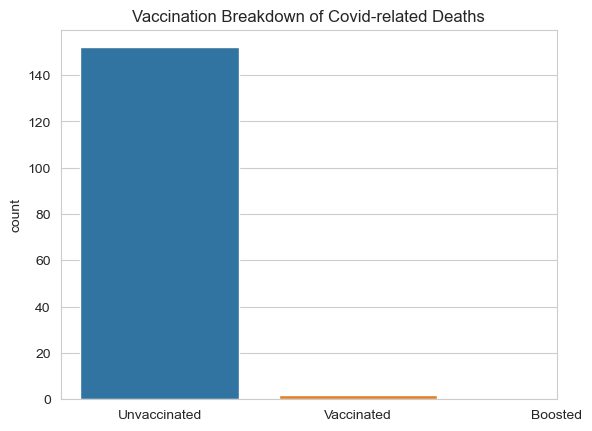

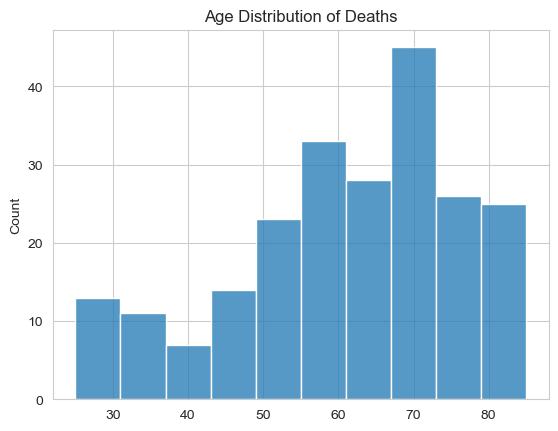

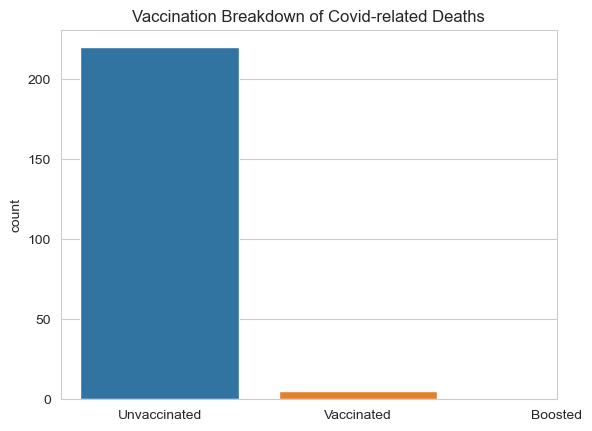

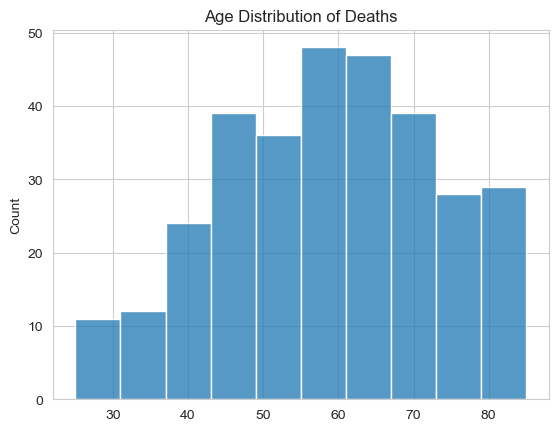

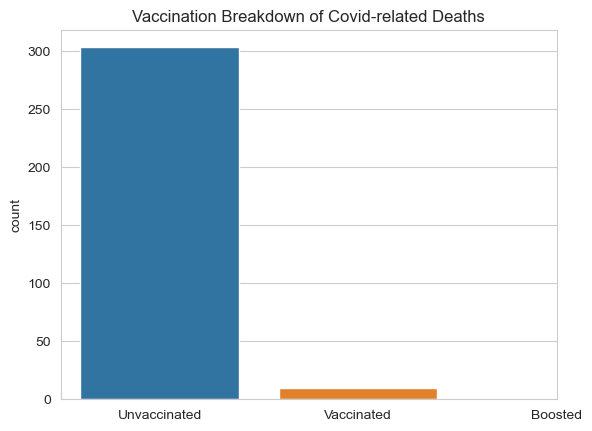

In [143]:
for sim, d in dict_simulations.items():
    ages = [int(x) for x in d['death']['age']]
    vaxxed = d['death']['vaccinated']
    if len(ages) > 5:
        sns.histplot(x=ages)
        plt.title('Age Distribution of Deaths')
        # Create a directory to save images in if not already existing
        try:
            os.mkdir(f'../images/{sim.split("/")[-1]}/')
            os.mkdir(f'../images/{sim.split("/")[-1]}/deaths/')
        except:
            pass
        plt.savefig(f'../images/{sim.split("/")[-1]}/deaths/age.png')
        plt.show()
        sns.countplot(x=vaxxed)
        plt.title('Vaccination Breakdown of Covid-related Deaths')
        plt.xticks([0,1,2], labels=['Unvaccinated', 'Vaccinated', 'Boosted'])
        plt.savefig(f"../images/{sim.split('/')[-1]}/deaths/vaccinated.png")
        plt.show()

### Percentage Plots

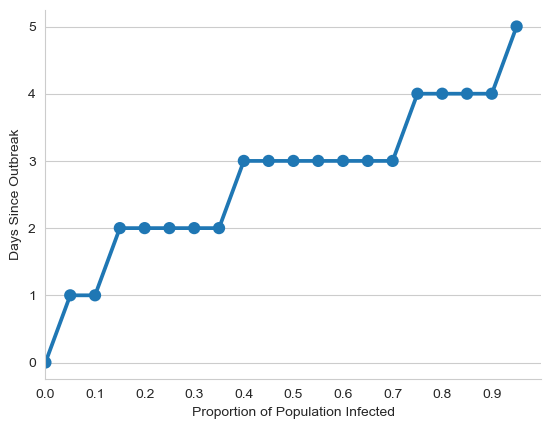

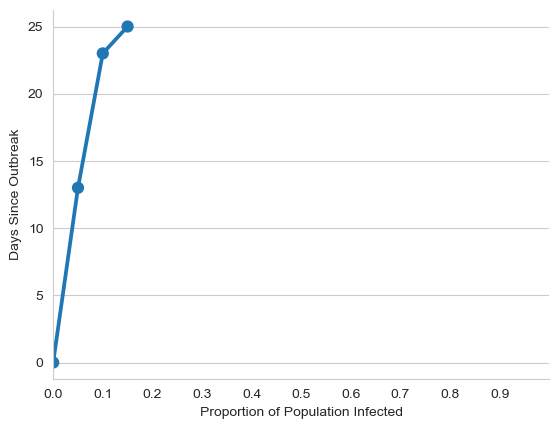

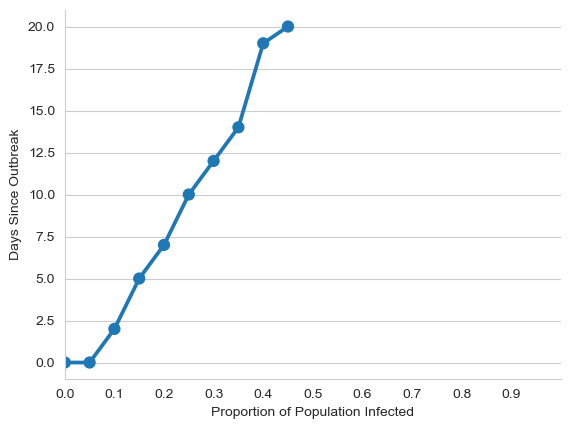

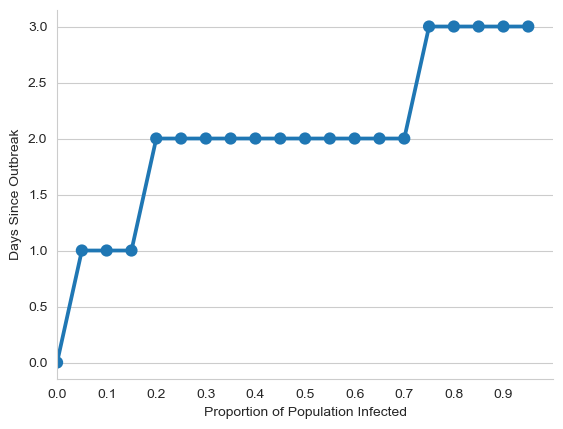

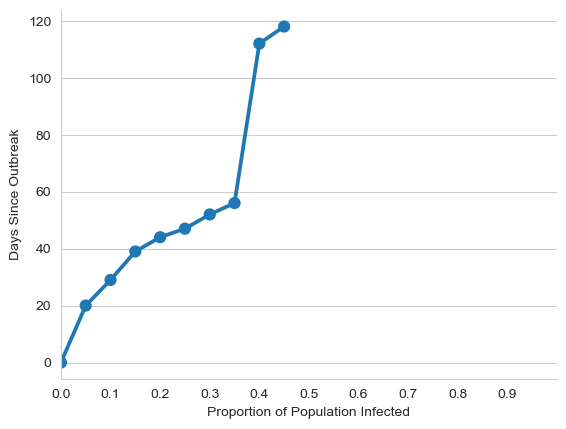

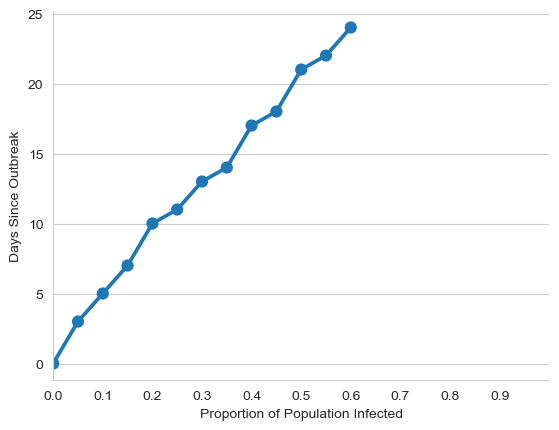

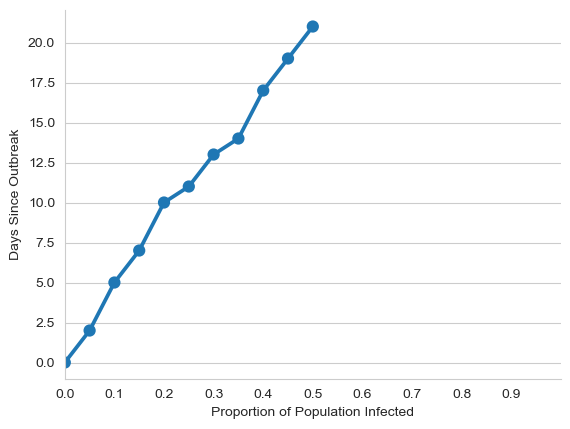

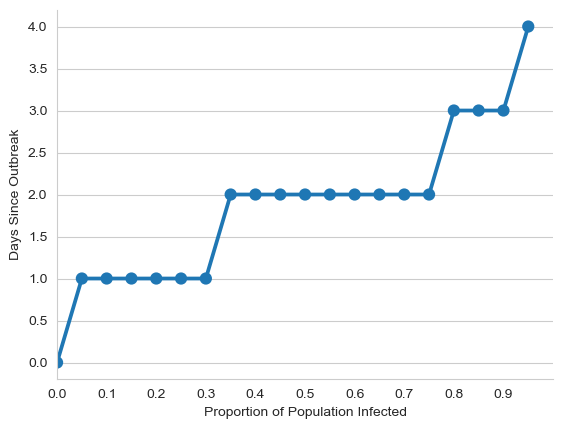

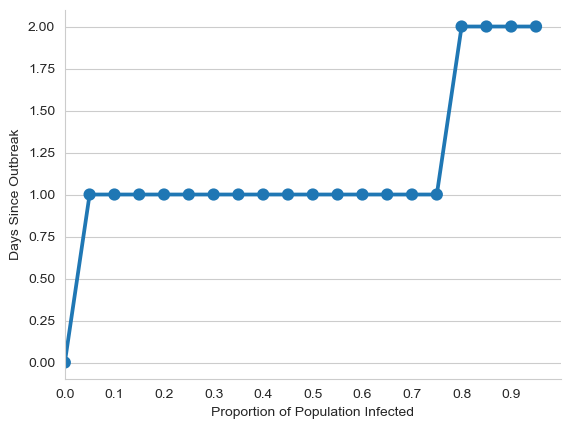

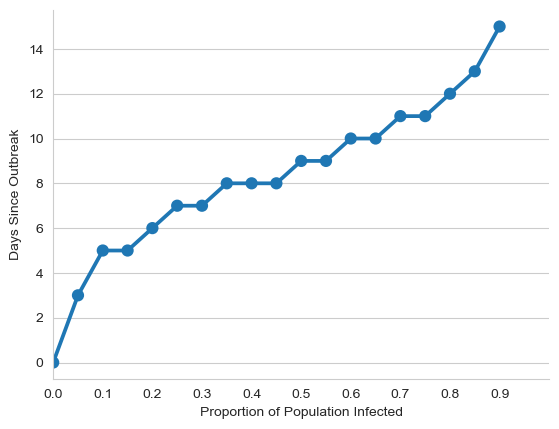

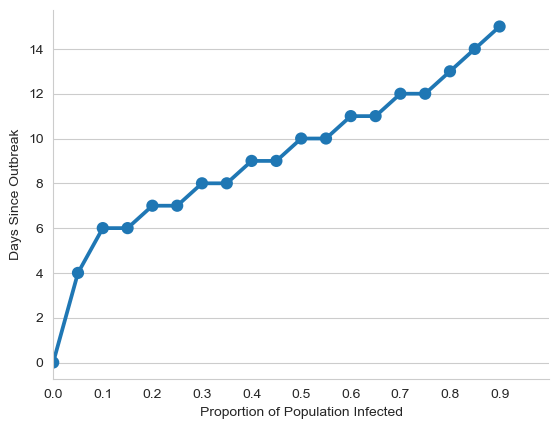

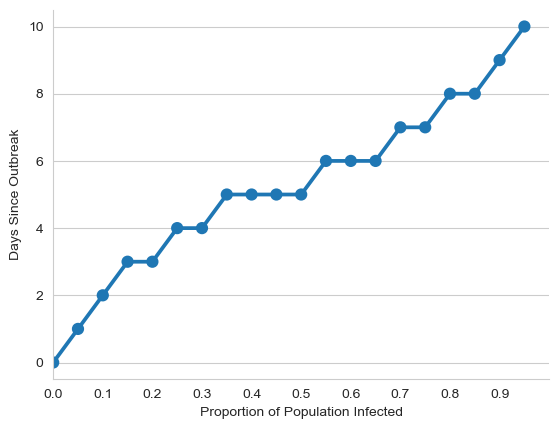

In [50]:
df_prop = pd.DataFrame()
for path in get_paths():
    sim = path.split('/')[-1]
    df_tmp = pd.DataFrame()
    dict_location = dict_simulations[path]['location']

    # Calculating the number of days or steps in simulation, some were shutdown early
    steps = len(dict_location.keys()) - 1 if len(dict_location.keys()) < 1001 else 1001

    status = [(
        len(dict_location[str(i)]['healthy']['x']) +\
        len(dict_location[str(i)]['recovered']['x']), 
        len(dict_location[str(i)]['infected']['x'])
    ) for i in range(steps)]
    infection_rates = [t[1] / sum(t) if sum(t) > 0 else 0 for t in status]
    prop_days = []
    for prop in np.arange(0, 1.0, 0.05):
        # Finding the first day infection rate passes a threshold
        try:
            idx = [r > prop for r in infection_rates].index(True)
            prop_days.append(idx)
        
        # Handling an index error if it never reached a certain threshold
        except ValueError:
            prop_days.append(np.nan)
    df_tmp['InfectionProportion'] = [round(x,3) for x in np.arange(0,1,0.05)]
    df_tmp['DaysSinceOutbreak'] = prop_days
    df_tmp['Simulation'] = sim
    df_tmp['OutbreakType'] = df_tmp.Simulation.map(dict_sim_severity)
    df_tmp['PopulationDensity'] = df_tmp.Simulation.map(dict_sim_density)
    df_tmp['InfectionRate'] = df_tmp.Simulation.map(dict_sim_infection)
    df_tmp['MortalityRate'] = df_tmp.Simulation.map(dict_sim_mortality)
    df_prop = pd.concat([df_prop, df_tmp])
    sns.pointplot(data=df_tmp,x='InfectionProportion', y='DaysSinceOutbreak')
    plt.xlim(0,20)
    plt.xlabel('Proportion of Population Infected')
    plt.ylabel('Days Since Outbreak')
    plt.locator_params(nbins=10)
    plt.show();

In [113]:
df_prop

,InfectionProportion,DaysSinceOutbreak,Simulation,OutbreakType,PopulationDensity,InfectionRate,MortalityRate
0,0.00,0.0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4,Severe,Lower,Moderate,Low
1,0.05,1.0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4,Severe,Lower,Moderate,Low
2,0.10,1.0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4,Severe,Lower,Moderate,Low
3,0.15,2.0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4,Severe,Lower,Moderate,Low
4,0.20,2.0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4,Severe,Lower,Moderate,Low
...,...,...,...,...,...,...,...
15,0.75,7.0,Pop900_ICR0.04_Fert0.05_Mort20.0_CCP0.99_Dist4,Moderate,High,High,Moderate
16,0.80,8.0,Pop900_ICR0.04_Fert0.05_Mort20.0_CCP0.99_Dist4,Moderate,High,High,Moderate
17,0.85,8.0,Pop900_ICR0.04_Fert0.05_Mort20.0_CCP0.99_Dist4,Moderate,High,High,Moderate
18,0.90,9.0,Pop900_ICR0.04_Fert0.05_Mort20.0_CCP0.99_Dist4,Moderate,High,High,Moderate


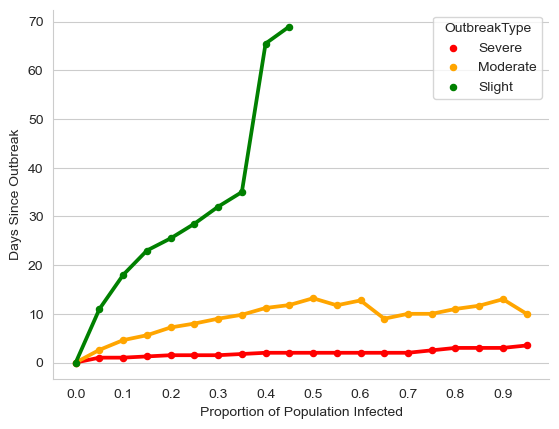

In [51]:
sns.set_style('whitegrid')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
sns.pointplot(
    data=df_prop.sort_values('MortalityRate'), x='InfectionProportion', y='DaysSinceOutbreak', 
    hue='OutbreakType', errorbar=None, palette=['red', 'orange', 'green'], markers='.')
plt.locator_params(nbins=10)
plt.xlabel('Proportion of Population Infected')
plt.ylabel('Days Since Outbreak')
plt.savefig('../images/overview/virus_transmission.png');

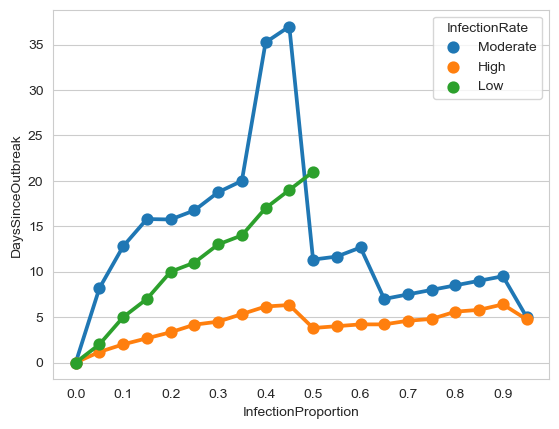

In [ ]:
sns.pointplot(data=df_prop, x='InfectionProportion', y='DaysSinceOutbreak', hue='InfectionRate', errorbar=None)
plt.locator_params(nbins=10);

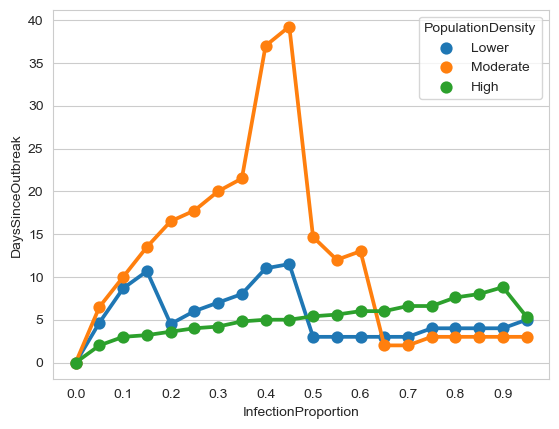

In [110]:
sns.pointplot(data=df_prop, x='InfectionProportion', y='DaysSinceOutbreak', hue='PopulationDensity', errorbar=None)
plt.locator_params(nbins=10);

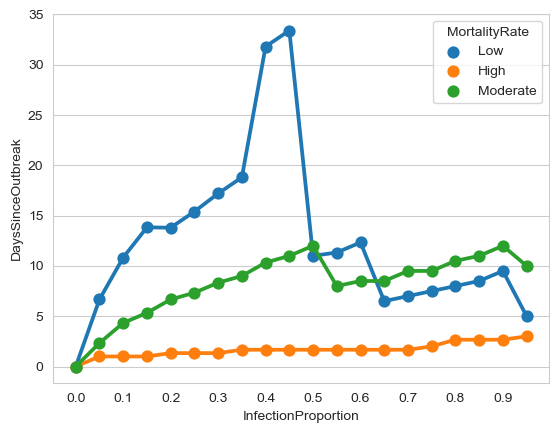

In [108]:
sns.pointplot(data=df_prop, x='InfectionProportion', y='DaysSinceOutbreak', hue='MortalityRate', errorbar=None)
plt.locator_params(nbins=10)


### Survivor Analysis

In [53]:
df_survivors = pd.DataFrame()
for path in get_paths():
    df_tmp = pd.DataFrame()
    sim = path.split('/')[-1]
    dict_composition = dict_simulations[path]['composition']

    # Selecting survivors by filtering data on the last day of simulation
    dict_survivors = dict_composition[str(len(dict_composition) - 1)]
    female_survivors = [[int(age), 'Female'] for age in dict_survivors['female']]
    male_survivors = [[int(age), 'Male'] for age in dict_survivors['male']]
    df_tmp[['Age', 'Sex']] = male_survivors + female_survivors
    df_tmp['OutbreakType'] = dict_sim_severity[sim]
    df_tmp['InfectionProb'] = dict_sim_severity[sim]
    df_tmp['PopulationDensity'] = dict_sim_density[sim]
    df_tmp['MortalityRate'] = dict_sim_mortality[sim]
    df_survivors = pd.concat([df_survivors, df_tmp])

In [54]:
df_survivors

,Age,Sex,OutbreakType,InfectionProb,PopulationDensity,MortalityRate
0,15,Male,Severe,Severe,Lower,Low
1,11,Male,Severe,Severe,Lower,Low
2,51,Male,Severe,Severe,Lower,Low
3,6,Male,Severe,Severe,Lower,Low
4,17,Male,Severe,Severe,Lower,Low
...,...,...,...,...,...,...
608,0,Female,Moderate,Moderate,High,Moderate
609,0,Female,Moderate,Moderate,High,Moderate
610,0,Female,Moderate,Moderate,High,Moderate
611,0,Female,Moderate,Moderate,High,Moderate


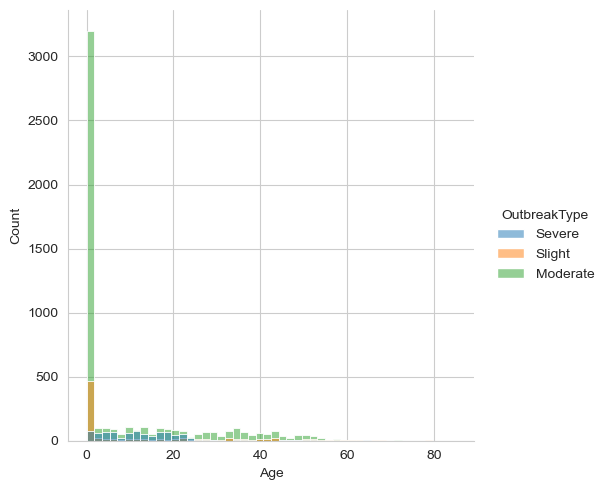

In [56]:
sns.displot(data=df_survivors, x='Age', hue='OutbreakType');

In [155]:
path = get_paths()[0]
sim = path.split('/')[-1]
dict_location = dict_simulations[path]['location']
df_composition = pd.DataFrame(
    [
    (len(d['healthy']['x']), 
     len(d['infected']['x']), 
     len(d['recovered']['x'])
     ) for d in dict_location.values()
     ], 
    columns=['Healthy','Infected','Recovered']
    ).reset_index().rename({'index':'Day'},axis=1)
df_composition['Simulation'] = sim
df_composition


,Day,Healthy,Infected,Recovered,Simulation
0,0,99,1,0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
1,1,89,11,0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
2,2,64,36,0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
3,3,27,73,0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
4,4,5,95,0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
...,...,...,...,...,...
149,149,1,79,1,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
150,150,1,80,0,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
151,151,1,79,1,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
152,152,1,76,3,Pop100_ICR0.01_Fert0.05_Mort4.0_CCP0.75_Dist4
